In [180]:
import pandas as pd
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords 
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
import numpy as np
from keras.layers import Embedding, SimpleRNN,Input
from keras.models import Sequential,Model
from keras.preprocessing import sequence
from keras.layers import Dense,Dropout
from keras.layers import Embedding, Flatten, Dense,Conv1D,MaxPooling1D
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools    
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from collections import Counter

**LOAD DATA**

In [151]:
election = pd.read_csv('election.csv')

In [154]:
election.head()

,id,clean_text,polarity,place
0,1.11772E+18,RT chitraSD Jogging RahulGandhi ’ memory famil...,0,Madras
1,1118061974292533249,AAP INC want alliance stop division Anti-Modi ...,0,NaN
2,1117870131969810432,RT pankaj_shankar She priyankagandhi slams Mod...,0,NaN
3,1.1177E+18,RT airnewsalerts SC says RahulGandhi 's remark...,0,New Delhi
4,1117850484327366656,RT sachinsingh1010 75 year old Govindraj kille...,0,New Delhi Varanasi


Despite the initial cleaning of the tweets there have some unnecessry elements like 'RT' and the URL's. Let's further clean the tweets before moving ahead. The below function will remove 'RT',the URL's, converts the text to lower case and allows only alphabets to be contained in the tweet.

In [145]:
def tweet_to_words( raw_review ):
    # Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review)
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', letters_only) # remove URLs
    tweet = re.sub('RT', ' ', str(tweet)) 

    #Convert to lower case, split into individual words
    tweet = letters_only.lower().split()                             
    
    
    
    return( " ".join(tweet))

In [148]:
# Get the number of Tweets based on the dataframe column size
num_tweets = 10365

# Initialize an empty list to hold the clean reviews
clean_train_tweets = []

# Loop over each tweet; create an index i that goes from 0 to the length
# of the tweet list 
for i in range( 0, num_tweets ):
    # Call function for each one, and add the result to the list of
    # clean reviews
    clean_train_tweets.append( tweet_to_words( election["clean_text"][i] ) )

In [159]:
data_inputs =  clean_train_tweets
data_labels = list(election.polarity)

**TOKENIZING DATA**

We tokenize the text and keep the maximum length of the the vector 1000.

In [170]:
tokenizer = Tokenizer(nb_words=2000)
tokenizer.fit_on_texts(data_inputs)
sequences = tokenizer.texts_to_sequences(data_inputs)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=1000)

labels = keras.utils.to_categorical(np.asarray(data_labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 8213 unique tokens.
Shape of data tensor: (10365, 1000)
Shape of label tensor: (10365, 2)


**TRAIN TEST SPLIT WITH 80:20 RATIO**

In [184]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(.20 * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

**CREATING EMBEDDING MATRIX WITH HELP OF PRETRAINED MODEL: GLOVE**

Word Embeddings are text converted into numbers. There are number of ways to represent the numeric forms.<br>

Types of embeddings: Frequency based, Prediction based.<br>Frequency Based: Tf-idf, Co-occurrence matrix<br>

Prediction-Based: BOW, Skip-gram model
Using Pre-trained word vectors: Word2vec, Glove

Word Embedding is done for the experiment with the pre trained word vector Glove.

Glove version used : 100-dimensional GloVe embeddings of 400k words computed on a 2014 dump of English Wikipedia. Training is performed on an aggregated global word-word co-occurrence matrix, giving us a vector space with meaningful substructures

In [174]:
embeddings_index = {}
f = open( r'C:/Users/Abhishek/Untitled Folder 1/glove.6B.100d.txt', encoding ="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [175]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Creating an embedding layer using GloVe

In [178]:
embedding_layer = Embedding(len(word_index) + 1,
                            100,
                            weights=[embedding_matrix],
                            input_length=1000,
                            trainable=False)

**MODEL CREATION**

In [232]:
def model_creation():
  input_layer = Input(shape=(1000,), dtype='int32')
  embed_layer = embedding_layer(input_layer)
  x = Dense(100,activation='relu')(embed_layer)
  x = Dense(50,activation='relu', kernel_regularizer=keras.regularizers.l2(0.002))(x)
  x = Flatten()(x)
  x = Dense(50,activation='relu', kernel_regularizer=keras.regularizers.l2(0.002))(x)
  x = Dropout(0.5)(x)
  x = Dense(50, activation='relu')(x)
  x = Dropout(0.5)(x)
  #x = Dense(512, activation='relu')(x)
  #x = Dropout(0.4)(x)
  final_layer = Dense(1, activation='sigmoid')(x)
  opt = keras.optimizers.Adam(lr= learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  model = Model(input_layer,final_layer)
  model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['acc'])
  return model

**MODEL ARCHITECTURE**

In [211]:
model_glove.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         821400    
_________________________________________________________________
dense_11 (Dense)             (None, 1000, 100)         10100     
_________________________________________________________________
dense_12 (Dense)             (None, 1000, 50)          5050      
_________________________________________________________________
flatten_3 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                2500050   
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
__________

In [187]:
learning_rate = 0.0001
batch_size = 1024
epochs = 10
model_glove = model_creation()
model_final = model_glove.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=epochs, batch_size=batch_size)

Train on 8292 samples, validate on 2073 samples
Epoch 1/10
8292/8292 [==============================] - 19s 2ms/step - loss: 0.9997 - acc: 0.5675 - val_loss: 0.9581 - val_acc: 0.6503
Epoch 2/10
8292/8292 [==============================] - 17s 2ms/step - loss: 0.9400 - acc: 0.6296 - val_loss: 0.8996 - val_acc: 0.7062
Epoch 3/10
8292/8292 [==============================] - 18s 2ms/step - loss: 0.8877 - acc: 0.6605 - val_loss: 0.8449 - val_acc: 0.7313
Epoch 4/10
8292/8292 [==============================] - 18s 2ms/step - loss: 0.8425 - acc: 0.6778 - val_loss: 0.7976 - val_acc: 0.7453
Epoch 5/10
8292/8292 [==============================] - 18s 2ms/step - loss: 0.7996 - acc: 0.7067 - val_loss: 0.7549 - val_acc: 0.7501
Epoch 6/10
8292/8292 [==============================] - 17s 2ms/step - loss: 0.7643 - acc: 0.7166 - val_loss: 0.7181 - val_acc: 0.7622
Epoch 7/10
8292/8292 [==============================] - 17s 2ms/step - loss: 0.7329 - acc: 0.7332 - val_loss: 0.6841 - val_acc: 0.7747
Epoch 8

The model gave a good preformance for just 10 epochs. The accuracy for both the training and validation was increasing steadily and the loss for the model was also decreasing.<br>
Let's now continue training the model from where the model had left(10th epoch). 

In [194]:
model_final = model_glove.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=100, batch_size=batch_size)

Train on 8292 samples, validate on 2073 samples
Epoch 1/100
8292/8292 [==============================] - 19s 2ms/step - loss: 0.6153 - acc: 0.7871 - val_loss: 0.5660 - val_acc: 0.8037
Epoch 2/100
8292/8292 [==============================] - 18s 2ms/step - loss: 0.5975 - acc: 0.7958 - val_loss: 0.5480 - val_acc: 0.8162
Epoch 3/100
8292/8292 [==============================] - 18s 2ms/step - loss: 0.5812 - acc: 0.8052 - val_loss: 0.5335 - val_acc: 0.8254
Epoch 4/100
8292/8292 [==============================] - 18s 2ms/step - loss: 0.5621 - acc: 0.8160 - val_loss: 0.5185 - val_acc: 0.8297
Epoch 5/100
8292/8292 [==============================] - 18s 2ms/step - loss: 0.5465 - acc: 0.8254 - val_loss: 0.5056 - val_acc: 0.8408
Epoch 6/100
8292/8292 [==============================] - 17s 2ms/step - loss: 0.5367 - acc: 0.8243 - val_loss: 0.4907 - val_acc: 0.8370
Epoch 7/100
8292/8292 [==============================] - 17s 2ms/step - loss: 0.5194 - acc: 0.8302 - val_loss: 0.4805 - val_acc: 0.8500


In [233]:
model_final1 = model_glove.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=20, batch_size=batch_size)

Train on 8292 samples, validate on 2073 samples
Epoch 1/20
8292/8292 [==============================] - 18s 2ms/step - loss: 0.1693 - acc: 0.9820 - val_loss: 0.1960 - val_acc: 0.9677
Epoch 2/20
8292/8292 [==============================] - 18s 2ms/step - loss: 0.1662 - acc: 0.9819 - val_loss: 0.1995 - val_acc: 0.9696
Epoch 3/20
8292/8292 [==============================] - 18s 2ms/step - loss: 0.1679 - acc: 0.9819 - val_loss: 0.1957 - val_acc: 0.9677
Epoch 4/20
8292/8292 [==============================] - 18s 2ms/step - loss: 0.1671 - acc: 0.9831 - val_loss: 0.1944 - val_acc: 0.9691
Epoch 5/20
8292/8292 [==============================] - 18s 2ms/step - loss: 0.1653 - acc: 0.9847 - val_loss: 0.1938 - val_acc: 0.9686
Epoch 6/20
8292/8292 [==============================] - 18s 2ms/step - loss: 0.1637 - acc: 0.9841 - val_loss: 0.1936 - val_acc: 0.9677
Epoch 7/20
8292/8292 [==============================] - 18s 2ms/step - loss: 0.1617 - acc: 0.9856 - val_loss: 0.1927 - val_acc: 0.9682
Epoch 8

**SAVE BEST MODEL AND WEIGHTS**

In [218]:
# serialize model to JSON
model_json = model_glove.to_json()
with open(".\\SavedModels\\Model_glove.h5", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_glove.save_weights(".\\SavedModels\\Weights_glove.h5")
print("Saved model to disk")

Saved model to disk


**MODEL LOSS AND ACCURAY**

In [210]:
loss,acc = model_glove.evaluate(x_val,y_val, verbose = 2, batch_size = batch_size)
print("Validation Loss: %.2f" % (loss))
print("Validation Accuracy: %.2f" % (acc))

Validation Loss: 0.20
Validation Accuracy: 0.97


**MODEL PERFORMANCE**

In [214]:
def plot_modelacc(fit_model):
    with plt.style.context('ggplot'):
            plt.plot(fit_model.history['acc'])
            plt.plot(fit_model.history['val_acc'])
            plt.ylim(0,1)
            plt.title("MODEL ACCURACY")
            plt.xlabel("# of EPOCHS")
            plt.ylabel("ACCURACY")
            plt.legend(['train', 'test'], loc='upper left')
    return plt.show()

In [215]:
def plot_model_loss(fit_model):
    with plt.style.context('ggplot'):
            plt.plot(fit_model.history['loss'])
            plt.plot(fit_model.history['val_loss'])
            plt.title("MODEL LOSS")
            plt.xlabel("# of EPOCHS")
            plt.ylabel("LOSS")
            plt.legend(['train', 'test'], loc='upper left')
    return plt.show()

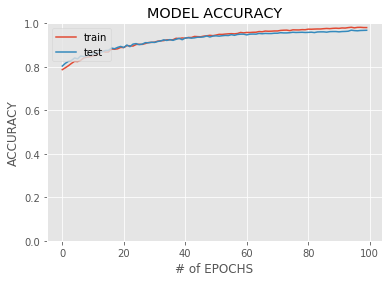

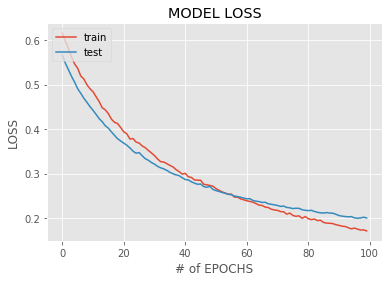

In [216]:
plot_modelacc(model_final)
plot_model_loss(model_final)

**CONFUSION MATRIX**

A confusion matrix will show us the how the model predicted with respect to the acutal output. 

[[1141   33]
 [  29  870]]


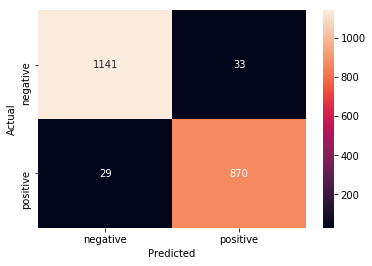

In [242]:
# Predicting the Test set results
y_pred = model_glove.predict(x_val)
# cutoff 0.5
y_pred = (y_pred > 0.5)

y_pred = y_pred.astype(int)


# Confusion matrix 
cm = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)

LABELS = ['negative', 'positive']
sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actual")

True Positives: 870 (Predicted True and True in reality)<br>
True Negative: 1141(Predicted False and False in realtity)<br>
False Positive: 33 (Predicted Positve but Negative in reality)<br>
False Negative: 29 (Predicted Negative but Positive in reality)